# CloudSat LRF construct

## imprt pacakge

In [1]:
import sys
import numpy as np
import joblib as jl
import netCDF4 as nc
from joblib import Parallel, delayed
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
np.set_printoptions(threshold=sys.maxsize)

from metpy.units import units
from metpy.calc import *


## Load data

In [2]:
# name of CloudSat data
fname: str = '/work/b11209013/LRF/data/CloudSat/CloudSat_array.pkl'

data: dict[str] = jl.load(fname)

i: int = 8

lon : np.ndarray[float] = data['lon'][i*357:(i+2)*357]
lat : np.ndarray[float] = data['lat'][i*357:(i+2)*357]
hgt : np.ndarray[float] = data['hgt'][i*357:(i+2)*357]
qlw : np.ndarray[float] = data['qlw'][i*357:(i+2)*357]
qsw : np.ndarray[float] = data['qsw'][i*357:(i+2)*357]

ldate, lswath, lray, lbin = qsw.shape

del data

### load variables

## Chunking data

In [3]:
# Set pressure levels as MPAS LRF
p_lev = np.linspace(150, 1000, 18)

# Convert into height coordinate
h_lev = np.array(pressure_to_height_std(p_lev * units('hPa'))) * 1000  # shape (18,)

# Reshape the data to 2D: (N, original_height_levels)
N = ldate * lswath * lray
hgt_flat = hgt.reshape(N, -1)  # shape (N, original_height_levels)
qlw_flat = qlw.reshape(N, -1)
qsw_flat = qsw.reshape(N, -1)

# Function to perform interpolation for a single profile
def interpolate_profile_parallel(n):
    hgt_temp = hgt_flat[n]
    qlw_temp = qlw_flat[n]
    qsw_temp = qsw_flat[n]
    
    # Interpolate qlw
    if np.all(np.isnan(qlw_temp)):
        qlw_itp_temp = np.full_like(h_lev, np.nan)
    else:
        valid = ~np.isnan(qlw_temp)
        if np.sum(valid) < 2:
            qlw_itp_temp = np.full_like(h_lev, np.nan)
        else:
            h_sorted = hgt_temp[valid]
            q_sorted = qlw_temp[valid]
            sorted_indices = np.argsort(h_sorted)
            h_sorted = h_sorted[sorted_indices]
            q_sorted = q_sorted[sorted_indices]
            try:
                interp_func = interp1d(h_sorted, q_sorted, kind='cubic', bounds_error=False, fill_value='extrapolate')
                qlw_itp_temp = interp_func(h_lev)
            except:
                qlw_itp_temp = np.full_like(h_lev, np.nan)
    
    # Interpolate qsw
    if np.all(np.isnan(qsw_temp)):
        qsw_itp_temp = np.full_like(h_lev, np.nan)
    else:
        valid = ~np.isnan(qsw_temp)
        if np.sum(valid) < 2:
            qsw_itp_temp = np.full_like(h_lev, np.nan)
        else:
            h_sorted = hgt_temp[valid]
            q_sorted = qsw_temp[valid]
            sorted_indices = np.argsort(h_sorted)
            h_sorted = h_sorted[sorted_indices]
            q_sorted = q_sorted[sorted_indices]
            try:
                interp_func = interp1d(h_sorted, q_sorted, kind='cubic', bounds_error=False, fill_value='extrapolate')
                qsw_itp_temp = interp_func(h_lev)
            except:
                qsw_itp_temp = np.full_like(h_lev, np.nan)
    
    return qlw_itp_temp, qsw_itp_temp

# Parallel processing
results = Parallel(n_jobs=-1, backend='loky')(delayed(interpolate_profile_parallel)(n) for n in range(N))

# Separate the results
qlw_itp_flat, qsw_itp_flat = zip(*results)
qlw_itp_flat = np.array(qlw_itp_flat)
qsw_itp_flat = np.array(qsw_itp_flat)

# Reshape back to original multi-dimensional shape
qlw_itp = qlw_itp_flat.reshape(ldate, lswath, lray, 18)
qsw_itp = qsw_itp_flat.reshape(ldate, lswath, lray, 18)

[ -0.46273848  -1.19732709  -1.76096734  -1.24507801  -0.98530221
  -2.03997462  -2.40078467  -1.97075861  -2.73315696  -2.75312828
  -2.47975803  -4.20354641 -22.55806574  -0.71965378  -0.7905653
  -0.80168786  -0.44580589   9.91439896]


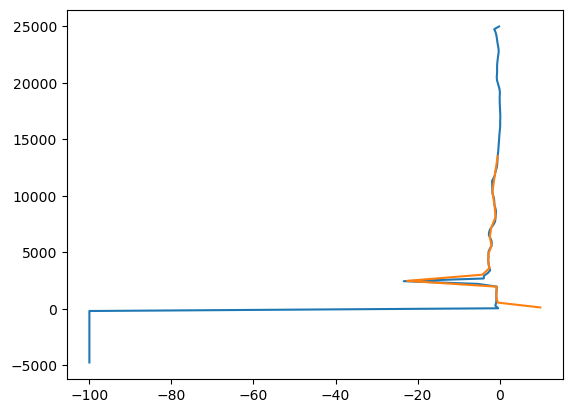

In [4]:
plt.plot(qlw[0, 0, 0], hgt[0, 0, 0])
plt.plot(qlw_itp[0, 0, 0], h_lev)
print(qlw_itp[0, 0, 0])

In [5]:
output_dict = {
    'lon': lon,
    'lat': lat,
    'hgt': p_lev,
    'qlw': qlw_itp,
    'qsw': qsw_itp,
}

jl.dump(output_dict, f'/work/b11209013/2024_Research/CloudSat/CloudSat_itp_{i:003}.joblib')

['/work/b11209013/2024_Research/CloudSat/CloudSat_itp_008.joblib']